#**Stock Price Forecasting with ML**

###This project uses real stock data (2000–2025) to forecast future prices like Open, Close, High, and Low using machine learning. By testing 9 popular models (KNN, XGBoost, LightGBM, etc.) across different day windows, we identify which setups predict best. The goal? Turn historical trends into smart predictions — with clear visualizations and reusable trained models.

##Importing Libraries

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import pickle

import warnings
warnings.filterwarnings("ignore")

##Loading the Dataset

###This dataset contains stock market prices from 2000 to 2025

In [15]:
df = pd.read_csv('/content/2000_to_2025.csv')
df

,Index Name,Date,Open,High,Low,Close
0,NIFTY 50,2000-01-03,1482.15,1592.90,1482.15,1592.20
1,NIFTY 50,2000-01-04,1594.40,1641.95,1594.40,1638.70
2,NIFTY 50,2000-01-05,1634.55,1635.50,1555.05,1595.80
3,NIFTY 50,2000-01-06,1595.80,1639.00,1595.80,1617.60
4,NIFTY 50,2000-01-07,1616.60,1628.25,1597.20,1613.30
...,...,...,...,...,...,...
6329,NIFTY 50,2025-06-16,24732.35,24967.10,24703.60,24946.50
6330,NIFTY 50,2025-06-17,24977.85,24982.05,24813.70,24853.40
6331,NIFTY 50,2025-06-18,24788.35,24947.55,24750.45,24812.05
6332,NIFTY 50,2025-06-19,24803.25,24863.10,24733.40,24793.25


##Feature Engineering: Generating Sequences from Time Series

In [16]:
def return_pairs(column, days):
    prices = list(column)
    X = []
    y = []
    for i in range(len(prices) - days):
        X.append(prices[i:i+days])
        y.append(prices[i+days])
    return X, y

##Creating Feature-Target Pairs for Different Targets and Time Windows

In [45]:
target_columns = ['Open', 'Close', 'High', 'Low']
day_chunks =  [30, 45, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500]

In [18]:
chunked_data = {}

for col in target_columns:
    for days in day_chunks:
        key_X = f"X_{col}_{days}"
        key_y = f"y_{col}_{days}"
        X, y = return_pairs(df[col], days)
        chunked_data[key_X] = X
        chunked_data[key_y] = y

##Collecting X-y Pair Keys

In [19]:
chunk_pairs = []

for key in chunked_data.keys():
    if key.startswith("X_"):
        y_key = key.replace("X_", "y_")
        if y_key in chunked_data:
            chunk_pairs.append([key, y_key])

##Defining Regression Models to Evaluate

In [20]:
models = [
    ("LinearRegression", LinearRegression()),
    ("Ridge", Ridge()),
    ("RandomForest", RandomForestRegressor()),
    ("KNN", KNeighborsRegressor()),
    ("XGBoost", XGBRegressor(verbosity=0)),
    ("LightGBM", LGBMRegressor(verbosity=0)),
    ("GradientBoosting", GradientBoostingRegressor()),
    ("SVR", SVR()),
    ("Lasso", Lasso()),
]

##Model Training & Evaluation on All Feature Sets

In [21]:
trained_models = {}

for X, y in tqdm(chunk_pairs):

    X_data = chunked_data[X]
    y_data = chunked_data[y]

    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.1, random_state=42
    )

    for model_name, model in models:

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        train_mse = mean_squared_error(y_train, y_train_pred)
        train_rmse = np.sqrt(train_mse)

        y_test_pred = model.predict(X_test)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        test_rmse = np.sqrt(test_mse)

        key = model_name + '_' + X[2:]
        trained_models[key] = {
            'model': model,
            'train_mae': train_mae,
            'train_mse': train_mse,
            'train_rmse': train_rmse,
            'test_mae': test_mae,
            'test_mse': test_mse,
            'test_rmse': test_rmse
        }

  0%|          | 0/52 [00:00<?, ?it/s]

##Summary of Model Performances

In [33]:
results_df = pd.DataFrame([
    {"Model": name, **metrics}
    for name, metrics in trained_models.items()
])

results_df.sort_values(by = 'test_mae', ascending = True).head(5)

,Model,model,train_mae,train_mse,train_rmse,test_mae,test_mse,test_rmse
300,KNN_High_250,KNeighborsRegressor(),37.880833,3586.686453,59.888951,46.893300,4932.035831,70.228455
318,KNN_High_350,KNeighborsRegressor(),38.278661,3630.762834,60.255812,48.445192,5945.150637,77.104803
309,KNN_High_300,KNeighborsRegressor(),37.748158,3659.835889,60.496577,48.803311,5670.555836,75.303093
291,KNN_High_200,KNeighborsRegressor(),37.458094,3622.600775,60.188045,49.409739,5843.280627,76.441354
255,KNN_High_60,KNeighborsRegressor(),37.962883,3736.996403,61.130977,49.866131,6859.630595,82.822887


##Saving All Trained Models with Pickle

In [23]:
with open("trained_models_all.pkl", "wb") as f:
    pickle.dump(trained_models, f)

print("✅ All trained models saved successfully!")

✅ All trained models saved successfully!


##Visualizing MAE of KNN Across Chunks for Each Target

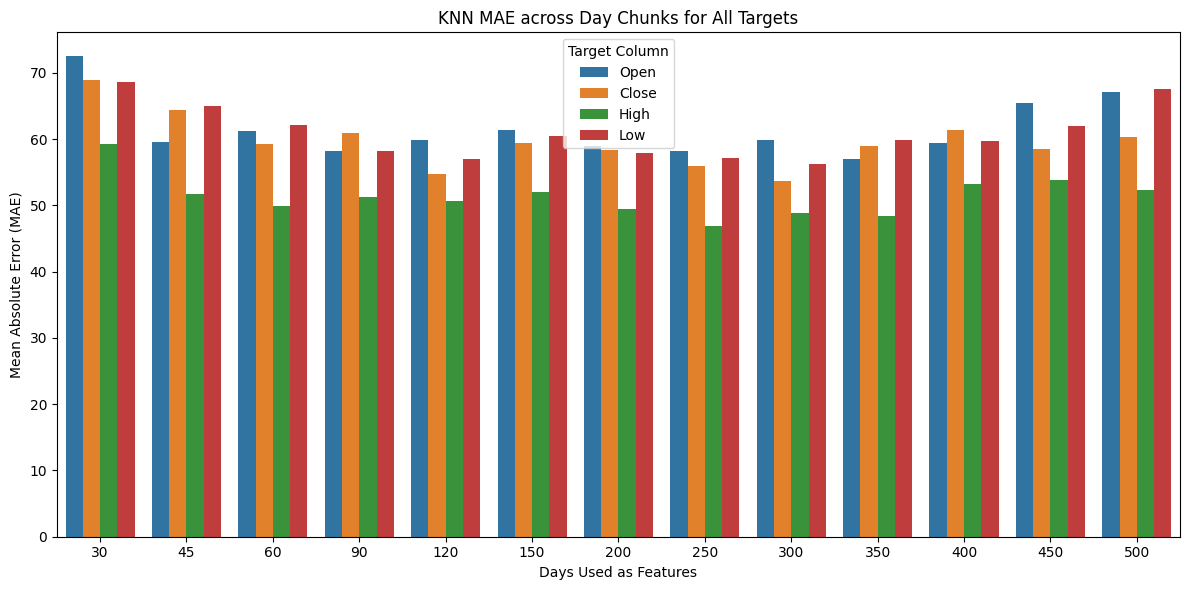

In [37]:
knn_results = {
    k: v for k, v in trained_models.items()
    if k.startswith("KNN")
}

knn_df = pd.DataFrame([
    {
        "Target": k.split('_')[1],        # Open / Close / High / Low
        "Days": int(k.split('_')[2]),     # 5, 15, ..., 200
        "MAE": v['test_mae']
    }
    for k, v in knn_results.items()
])

plt.figure(figsize=(12, 6))
sns.barplot(data=knn_df, x="Days", y="MAE", hue="Target")

plt.title("KNN MAE across Day Chunks for All Targets")
plt.ylabel("Mean Absolute Error (MAE)")
plt.xlabel("Days Used as Features")
plt.legend(title="Target Column")
plt.tight_layout()
plt.show()

##Final Model Visualization - KNN on High (250 Days)

In [38]:
X = chunked_data["X_High_250"]
y = chunked_data["y_High_250"]

model = KNeighborsRegressor()
model.fit(X, y)
y_pred = model.predict(X)

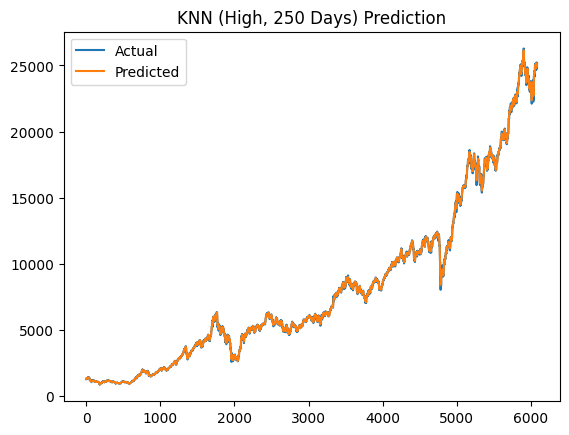

In [40]:
plt.plot(y, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("KNN (High, 250 Days) Prediction")
plt.show()